# Introduction

Find small single text files for **Language Modeling** experiements here ⬇️

https://www.kaggle.com/datasets/sovitrath/text-generation-language-modeling

In [1]:
import torch
import os
import numpy as np
import string
import re
import glob
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import math
import tiktoken

from tqdm.auto import tqdm
from utils.text_gen import get_batch, train, validate, NLPDataset
from collections import Counter
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim.lr_scheduler import StepLR
from attention.transformer_linear_decoder import Transformer

In [2]:
# Set seed.
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
!nvidia-smi

Sat Jun  3 20:22:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 30%   46C    P5    30W / 370W |    498MiB / 10009MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
CHECKPOINT_DIR = 'outputs/text_gen_simple_dec_alice' 
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [5]:
dataset_dir = os.path.join('../../input', 'alice_short_story')
train_file = os.listdir(dataset_dir)
print(train_file)

['alice.txt']


## Prepare the Dataset
Let's find the longest review in the entire training set. As this will also contain the <br> tags, we will take the average of that.

We will pad the smaller sentences to this average length and truncate the longer sentences to the average length.

In [6]:
def find_longest_length(text_file_paths):
    """
    Find the longest review length in the entire training set. 

    :param text_file_paths: List, containing all the text file paths.

    Returns:
        max_len: Longest review length.
    """
    max_length = 0
    for path in text_file_paths:
        with open(path, 'r') as f:
            text = f.read()
            corpus = [
                word for word in text.split()
            ]
        if len(corpus) > max_length:
            max_length = len(corpus)
    return max_length


file_paths = []
file_paths.extend(glob.glob(os.path.join(
    dataset_dir, '*.txt'
)))
longest_sentence_length = find_longest_length(file_paths)
print(f"Total words (possibly, without tokenization): {longest_sentence_length} words")

Total words (possibly, without tokenization): 1243 words


In [7]:
# Number of words to generate in a sentence.
SEQUENCE_LENGTH = 128
NUM_WORDS = 50304  # Vocabulary size.

# Batch size.
BATCH_SIZE = 1
VALID_SPLIT = 0.1
EPOCHS = 500

### Helper Functions 

A few helper functions to prepare the dataset.

In [8]:
def find_word_frequency(
    text_file_paths, num_files, most_common=None
):
    """
    Create a list of tuples of the following format,
    [('ho', 2), ('hello', 1), ("let's", 1), ('go', 1)]
    where the number represents the frequency of occurance of 
    the word in the entire dataset.

    :param text_file_paths: List, containing all the text file paths.
    :param most_common: Return these many top words from the dataset.
        If `most_common` is None, return all. If `most_common` is 3,
        returns the top 3 tuple pairs in the list.

    Returns:
        sorted_words: A list of tuple containing each word and it's
        frequency of the format ('ho', 2), ('hello', 1), ...]
    """
    # Add all the words in the entire dataset to `corpus` list.
    corpus = []
    for i, path in enumerate(text_file_paths):
        if i+1 == num_files:
            break
        with open(path, 'r') as f:
            text = f.read()
            # Remove <br> tags.
            text = re.sub('<[^>]+>+', '', text)
            corpus.extend([
                word for word in text.split()
            ])
    count_words = Counter(corpus)
    # Create a dictionary with the most common word in the corpus 
    # at the beginning.
    # `word_frequency` will be like 
    word_frequency = count_words.most_common(n=most_common) # Returns all as n is `None`.
    return word_frequency

In [9]:
def word2int(input_words, num_words):
    """
    Create a dictionary of word to integer mapping for each unique word.

    :param input_words: A list of tuples containing the words and 
        theiry frequency. Should be of the following format,
        [('ho', 2), ('hello', 1), ("let's", 1), ('go', 1)]
    :param num_words: Number of words to use from the `input_words` list 
        to create the mapping. If -1, use all words in the dataset.

    Returns:
        int_mapping: A dictionary of word and a integer mapping as 
            key-value pair. Example, {'Hello,': 1, 'the': 2, 'let': 3}
    """

    if num_words > -1:
        int_mapping = {
            w:i+1 for i, (w, c) in enumerate(input_words) \
                if i <= num_words - 1 # -1 to avoid getting (num_words + 1) integer mapping.
        }
    else:
        int_mapping = {w:i+1 for i, (w, c) in enumerate(input_words)}
    return int_mapping

### Tiktoken

In [10]:
enc = tiktoken.encoding_for_model("gpt2")

## Prepare PyTorch Datasets and Data Loaders

In [11]:
file_paths = os.path.join(dataset_dir, train_file[0])

In [12]:
dataset_inst = NLPDataset(file_paths, enc)
dataset = dataset_inst.get_data()

In [13]:
print(f"Total tokens: {dataset.shape}")
print(f"Number of unique tokens: {len(np.unique(dataset))}")
# print(f"Number of chosen words to act as vocabulary (tokens): {len(int_mapping)}")

Total tokens: torch.Size([1536])
Number of unique tokens: 618


In [14]:
dataset_size = len(dataset)
# Calculate the validation dataset size.
valid_size = int(VALID_SPLIT*dataset_size)
# Radomize the data indices.
indices = torch.randperm(len(dataset)).tolist()
# Training and validation sets.
dataset_train = dataset[:-valid_size]
dataset_valid = dataset[-valid_size:]

print(f"Number of training samples: {len(dataset_train)}")
print(f"Number of validation samples: {len(dataset_valid)}")

Number of training samples: 1383
Number of validation samples: 153


In [15]:
print(dataset_train.size(0))
print(dataset_valid.size(0))

1383
153


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
# for i, batch in enumerate(dataset_train):
#     inp, tgt = get_batch('train')
#     print(inp)
#     print(tgt)
#     inp_words = ''
#     tgt_words = ''
#     inp = inp[0].cpu().numpy()
#     tgt = tgt[0].cpu().numpy()
#     print(len(inp))
#     print(len(tgt))
#     for idx in inp:
#         inp_words += ' ' + int2word_train[idx]
#     print(inp_words)
#     print('*'*50)
#     for idx in tgt:
#         tgt_words += ' ' + int2word_train[idx]
#     print(tgt_words)
#     if i == 2:
#         break

## Model

In [18]:
model = Transformer(
    embed_dim=512, 
    src_vocab_size=NUM_WORDS, 
    seq_len=SEQUENCE_LENGTH,
    num_layers=6, 
    expansion_factor=4, 
    n_heads=8,
)

In [19]:
_ = model.to(device)

## Training

In [20]:
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(), 
    lr=0.0001,
)

# StepLR every specific number of epochs.
scheduler = StepLR(
    optimizer, 
    step_size=5, 
    gamma=0.5,
    verbose=True
)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

Transformer(
  (encoder): TransformerEncoder(
    (embedding): Embedding(
      (embed): Embedding(50304, 512)
    )
    (positional_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadAttention(
          (q): Linear(in_features=64, out_features=64, bias=True)
          (k): Linear(in_features=64, out_features=64, bias=True)
          (v): Linear(in_features=64, out_features=64, bias=True)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): 

In [21]:
epochs = EPOCHS
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, 
        dataset_train, 
        optimizer, 
        criterion,
        SEQUENCE_LENGTH,
        NUM_WORDS,
        BATCH_SIZE,
        device
    )
    valid_epoch_loss = validate(
        model, 
        dataset_valid,  
        criterion,
        SEQUENCE_LENGTH,
        NUM_WORDS,
        BATCH_SIZE,
        device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Training loss: {train_epoch_loss}")
    print(f"Validation loss: {valid_epoch_loss}")

    # Save model.
    torch.save(
        model, os.path.join(CHECKPOINT_DIR, 'model.pth')
    )
    print('-'*50)
#     if epoch + 1 <= 32:
#         scheduler.step()

[INFO]: Epoch 1 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 10.347881663929332
Validation loss: 9.294590950012207
--------------------------------------------------
[INFO]: Epoch 2 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 9.219371622258967
Validation loss: 8.809160709381104
--------------------------------------------------
[INFO]: Epoch 3 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 8.265716205943715
Validation loss: 8.141219139099121
--------------------------------------------------
[INFO]: Epoch 4 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 7.62786306034435
Validation loss: 7.699601888656616
--------------------------------------------------
[INFO]: Epoch 5 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 6.952421795238148
Validation loss: 7.315540075302124
--------------------------------------------------
[INFO]: Epoch 6 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 6.58438136360862
Validation loss: 7.134166240692139
--------------------------------------------------
[INFO]: Epoch 7 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 6.154496236280962
Validation loss: 6.987320423126221
--------------------------------------------------
[INFO]: Epoch 8 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.856679049405185
Validation loss: 6.914860486984253
--------------------------------------------------
[INFO]: Epoch 9 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.907366665926847
Validation loss: 6.9233880043029785
--------------------------------------------------
[INFO]: Epoch 10 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.758253487673673
Validation loss: 6.85968542098999
--------------------------------------------------
[INFO]: Epoch 11 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.6876162182201035
Validation loss: 6.921160936355591
--------------------------------------------------
[INFO]: Epoch 12 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.668230793692849
Validation loss: 6.95535945892334
--------------------------------------------------
[INFO]: Epoch 13 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.545815771276301
Validation loss: 6.904570579528809
--------------------------------------------------
[INFO]: Epoch 14 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.5181332501498135
Validation loss: 6.943516254425049
--------------------------------------------------
[INFO]: Epoch 15 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.413018833507191
Validation loss: 6.964724540710449
--------------------------------------------------
[INFO]: Epoch 16 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.57430345361883
Validation loss: 6.933383464813232
--------------------------------------------------
[INFO]: Epoch 17 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.589700005271218
Validation loss: 6.954743146896362
--------------------------------------------------
[INFO]: Epoch 18 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.524701898748225
Validation loss: 7.038581848144531
--------------------------------------------------
[INFO]: Epoch 19 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.519621502269398
Validation loss: 7.0773704051971436
--------------------------------------------------
[INFO]: Epoch 20 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.460502581162886
Validation loss: 6.980066537857056
--------------------------------------------------
[INFO]: Epoch 21 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.455340168692849
Validation loss: 7.062245845794678
--------------------------------------------------
[INFO]: Epoch 22 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.591826568950307
Validation loss: 7.061264991760254
--------------------------------------------------
[INFO]: Epoch 23 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.438659971410578
Validation loss: 7.121183395385742
--------------------------------------------------
[INFO]: Epoch 24 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.488723321394487
Validation loss: 7.034464120864868
--------------------------------------------------
[INFO]: Epoch 25 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.445710225538774
Validation loss: 7.0827436447143555
--------------------------------------------------
[INFO]: Epoch 26 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.464479099620473
Validation loss: 7.162163734436035
--------------------------------------------------
[INFO]: Epoch 27 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.472751660780474
Validation loss: 7.161892414093018
--------------------------------------------------
[INFO]: Epoch 28 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.461068933660334
Validation loss: 7.182788610458374
--------------------------------------------------
[INFO]: Epoch 29 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.479591022838246
Validation loss: 7.19633150100708
--------------------------------------------------
[INFO]: Epoch 30 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.482394521886652
Validation loss: 7.088898420333862
--------------------------------------------------
[INFO]: Epoch 31 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.346225738525391
Validation loss: 7.017361402511597
--------------------------------------------------
[INFO]: Epoch 32 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.285270604220304
Validation loss: 7.087143898010254
--------------------------------------------------
[INFO]: Epoch 33 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.194865486838601
Validation loss: 6.8460211753845215
--------------------------------------------------
[INFO]: Epoch 34 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.263347885825417
Validation loss: 7.143038749694824
--------------------------------------------------
[INFO]: Epoch 35 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.240908752788197
Validation loss: 7.066112518310547
--------------------------------------------------
[INFO]: Epoch 36 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.18053505637429
Validation loss: 6.939861536026001
--------------------------------------------------
[INFO]: Epoch 37 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.159970933740789
Validation loss: 6.792581081390381
--------------------------------------------------
[INFO]: Epoch 38 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.060537424954501
Validation loss: 6.759602069854736
--------------------------------------------------
[INFO]: Epoch 39 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.969595995816317
Validation loss: 6.7952210903167725
--------------------------------------------------
[INFO]: Epoch 40 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.873233708468351
Validation loss: 6.824596166610718
--------------------------------------------------
[INFO]: Epoch 41 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.786405086517334
Validation loss: 6.906206130981445
--------------------------------------------------
[INFO]: Epoch 42 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.667899695309726
Validation loss: 6.771379232406616
--------------------------------------------------
[INFO]: Epoch 43 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.573113484816118
Validation loss: 6.8324127197265625
--------------------------------------------------
[INFO]: Epoch 44 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.521751057017934
Validation loss: 6.786804676055908
--------------------------------------------------
[INFO]: Epoch 45 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.662238077683882
Validation loss: 6.844186067581177
--------------------------------------------------
[INFO]: Epoch 46 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.559615612030029
Validation loss: 6.876965522766113
--------------------------------------------------
[INFO]: Epoch 47 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.264903545379639
Validation loss: 6.813069581985474
--------------------------------------------------
[INFO]: Epoch 48 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.415721329775724
Validation loss: 6.949118137359619
--------------------------------------------------
[INFO]: Epoch 49 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.415230469270186
Validation loss: 6.851974010467529
--------------------------------------------------
[INFO]: Epoch 50 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.419859539378773
Validation loss: 6.8952271938323975
--------------------------------------------------
[INFO]: Epoch 51 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.135932272130793
Validation loss: 6.998693943023682
--------------------------------------------------
[INFO]: Epoch 52 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.983594070781361
Validation loss: 6.9301598072052
--------------------------------------------------
[INFO]: Epoch 53 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.251389373432506
Validation loss: 6.950305700302124
--------------------------------------------------
[INFO]: Epoch 54 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.9145108569752085
Validation loss: 6.96961236000061
--------------------------------------------------
[INFO]: Epoch 55 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.7941350720145484
Validation loss: 7.0327723026275635
--------------------------------------------------
[INFO]: Epoch 56 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.8570107980207964
Validation loss: 6.985246658325195
--------------------------------------------------
[INFO]: Epoch 57 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.9444959380409936
Validation loss: 6.860261917114258
--------------------------------------------------
[INFO]: Epoch 58 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.666173306378451
Validation loss: 7.084282159805298
--------------------------------------------------
[INFO]: Epoch 59 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.6630770943381568
Validation loss: 7.111270904541016
--------------------------------------------------
[INFO]: Epoch 60 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.618844509124756
Validation loss: 7.052256345748901
--------------------------------------------------
[INFO]: Epoch 61 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.6555263129147617
Validation loss: 6.9423558712005615
--------------------------------------------------
[INFO]: Epoch 62 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.4448889168826016
Validation loss: 7.042368173599243
--------------------------------------------------
[INFO]: Epoch 63 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.4342270981181753
Validation loss: 6.929261922836304
--------------------------------------------------
[INFO]: Epoch 64 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.53130520473827
Validation loss: 7.093916893005371
--------------------------------------------------
[INFO]: Epoch 65 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.456706025383689
Validation loss: 7.194085359573364
--------------------------------------------------
[INFO]: Epoch 66 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.3355757106434214
Validation loss: 7.117192268371582
--------------------------------------------------
[INFO]: Epoch 67 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.294952544299039
Validation loss: 7.056527614593506
--------------------------------------------------
[INFO]: Epoch 68 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.272818782112815
Validation loss: 7.030097246170044
--------------------------------------------------
[INFO]: Epoch 69 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.3161002939397637
Validation loss: 6.965280532836914
--------------------------------------------------
[INFO]: Epoch 70 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.142116741700606
Validation loss: 6.934063911437988
--------------------------------------------------
[INFO]: Epoch 71 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.2041930068622935
Validation loss: 7.0138773918151855
--------------------------------------------------
[INFO]: Epoch 72 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.1271152062849565
Validation loss: 7.299388885498047
--------------------------------------------------
[INFO]: Epoch 73 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.022030613639138
Validation loss: 7.085879802703857
--------------------------------------------------
[INFO]: Epoch 74 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.024336338043213
Validation loss: 7.186350345611572
--------------------------------------------------
[INFO]: Epoch 75 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.0786610299890693
Validation loss: 7.000548362731934
--------------------------------------------------
[INFO]: Epoch 76 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.0031936818903144
Validation loss: 7.180518388748169
--------------------------------------------------
[INFO]: Epoch 77 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.7860714305530894
Validation loss: 7.139584302902222
--------------------------------------------------
[INFO]: Epoch 78 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.0613751194693823
Validation loss: 7.172134160995483
--------------------------------------------------
[INFO]: Epoch 79 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.0428329597819936
Validation loss: 7.2310850620269775
--------------------------------------------------
[INFO]: Epoch 80 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.84623215415261
Validation loss: 7.229152679443359
--------------------------------------------------
[INFO]: Epoch 81 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.8608595674688164
Validation loss: 7.2592902183532715
--------------------------------------------------
[INFO]: Epoch 82 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.9775125763633032
Validation loss: 7.184627532958984
--------------------------------------------------
[INFO]: Epoch 83 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.682370901107788
Validation loss: 7.282501220703125
--------------------------------------------------
[INFO]: Epoch 84 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.7070900310169566
Validation loss: 7.382453203201294
--------------------------------------------------
[INFO]: Epoch 85 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.61218937960538
Validation loss: 7.511274814605713
--------------------------------------------------
[INFO]: Epoch 86 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.5817154320803555
Validation loss: 7.4299845695495605
--------------------------------------------------
[INFO]: Epoch 87 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.66979380087419
Validation loss: 7.494695425033569
--------------------------------------------------
[INFO]: Epoch 88 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.716833569786765
Validation loss: 7.465981483459473
--------------------------------------------------
[INFO]: Epoch 89 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.5716828866438433
Validation loss: 7.185637474060059
--------------------------------------------------
[INFO]: Epoch 90 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.6451954408125444
Validation loss: 7.423928260803223
--------------------------------------------------
[INFO]: Epoch 91 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.5301635482094507
Validation loss: 7.316538095474243
--------------------------------------------------
[INFO]: Epoch 92 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.524309678511186
Validation loss: 7.335643768310547
--------------------------------------------------
[INFO]: Epoch 93 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.5239924517544834
Validation loss: 7.476496458053589
--------------------------------------------------
[INFO]: Epoch 94 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.489628553390503
Validation loss: 7.4075071811676025
--------------------------------------------------
[INFO]: Epoch 95 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.5037517330863257
Validation loss: 7.48751163482666
--------------------------------------------------
[INFO]: Epoch 96 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.3757127848538486
Validation loss: 7.540724515914917
--------------------------------------------------
[INFO]: Epoch 97 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.4731697169217197
Validation loss: 7.483021259307861
--------------------------------------------------
[INFO]: Epoch 98 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.3633973598480225
Validation loss: 7.601886987686157
--------------------------------------------------
[INFO]: Epoch 99 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.5394850210710005
Validation loss: 7.5857322216033936
--------------------------------------------------
[INFO]: Epoch 100 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.559639659794894
Validation loss: 7.550112009048462
--------------------------------------------------
[INFO]: Epoch 101 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.2582310329784048
Validation loss: 7.622032642364502
--------------------------------------------------
[INFO]: Epoch 102 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.4357147216796875
Validation loss: 7.491349935531616
--------------------------------------------------
[INFO]: Epoch 103 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.230244203047319
Validation loss: 7.464674472808838
--------------------------------------------------
[INFO]: Epoch 104 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.4356354691765527
Validation loss: 7.749457597732544
--------------------------------------------------
[INFO]: Epoch 105 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.2033251090483232
Validation loss: 7.440632343292236
--------------------------------------------------
[INFO]: Epoch 106 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.2537272518331353
Validation loss: 7.432347774505615
--------------------------------------------------
[INFO]: Epoch 107 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.1188797517256304
Validation loss: 7.455657958984375
--------------------------------------------------
[INFO]: Epoch 108 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.10124933719635
Validation loss: 7.471476793289185
--------------------------------------------------
[INFO]: Epoch 109 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.255679585716941
Validation loss: 7.610652923583984
--------------------------------------------------
[INFO]: Epoch 110 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.0035994052886963
Validation loss: 7.462547779083252
--------------------------------------------------
[INFO]: Epoch 111 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.0613202181729404
Validation loss: 7.631380796432495
--------------------------------------------------
[INFO]: Epoch 112 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.0950663631612603
Validation loss: 7.825747966766357
--------------------------------------------------
[INFO]: Epoch 113 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.126484816724604
Validation loss: 7.680736780166626
--------------------------------------------------
[INFO]: Epoch 114 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.9996090043674817
Validation loss: 7.674549341201782
--------------------------------------------------
[INFO]: Epoch 115 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.0285755179145117
Validation loss: 7.6325414180755615
--------------------------------------------------
[INFO]: Epoch 116 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.9986084374514492
Validation loss: 7.606287240982056
--------------------------------------------------
[INFO]: Epoch 117 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.2859625924717295
Validation loss: 7.951341152191162
--------------------------------------------------
[INFO]: Epoch 118 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.9638465642929077
Validation loss: 7.70249605178833
--------------------------------------------------
[INFO]: Epoch 119 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.8584927103736184
Validation loss: 7.702847957611084
--------------------------------------------------
[INFO]: Epoch 120 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.0194859938188032
Validation loss: 7.511536121368408
--------------------------------------------------
[INFO]: Epoch 121 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.0555295835841787
Validation loss: 7.859821557998657
--------------------------------------------------
[INFO]: Epoch 122 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.8690654797987505
Validation loss: 7.870502710342407
--------------------------------------------------
[INFO]: Epoch 123 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.011357079852711
Validation loss: 7.994176864624023
--------------------------------------------------
[INFO]: Epoch 124 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.9559146707708186
Validation loss: 7.935283899307251
--------------------------------------------------
[INFO]: Epoch 125 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.9384419918060303
Validation loss: 7.760061264038086
--------------------------------------------------
[INFO]: Epoch 126 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.109215346249667
Validation loss: 7.743361473083496
--------------------------------------------------
[INFO]: Epoch 127 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.814044865694913
Validation loss: 7.778115749359131
--------------------------------------------------
[INFO]: Epoch 128 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.00749053738334
Validation loss: 7.935997009277344
--------------------------------------------------
[INFO]: Epoch 129 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.8466489965265447
Validation loss: 8.00167441368103
--------------------------------------------------
[INFO]: Epoch 130 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.8002929579127918
Validation loss: 8.119701385498047
--------------------------------------------------
[INFO]: Epoch 131 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.042569323019548
Validation loss: 7.901322364807129
--------------------------------------------------
[INFO]: Epoch 132 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.8060988946394487
Validation loss: 7.919434547424316
--------------------------------------------------
[INFO]: Epoch 133 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.8080291531302712
Validation loss: 8.120890617370605
--------------------------------------------------
[INFO]: Epoch 134 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.8596887588500977
Validation loss: 7.879643440246582
--------------------------------------------------
[INFO]: Epoch 135 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.7158854766325518
Validation loss: 8.153250694274902
--------------------------------------------------
[INFO]: Epoch 136 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.7786272764205933
Validation loss: 8.121448516845703
--------------------------------------------------
[INFO]: Epoch 137 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.820857123895125
Validation loss: 8.068583011627197
--------------------------------------------------
[INFO]: Epoch 138 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.6250493634830823
Validation loss: 7.940296411514282
--------------------------------------------------
[INFO]: Epoch 139 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.6952311559156938
Validation loss: 8.076377868652344
--------------------------------------------------
[INFO]: Epoch 140 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.7859142801978372
Validation loss: 8.117089748382568
--------------------------------------------------
[INFO]: Epoch 141 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.7066607041792436
Validation loss: 7.998424530029297
--------------------------------------------------
[INFO]: Epoch 142 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.7975389957427979
Validation loss: 8.048235893249512
--------------------------------------------------
[INFO]: Epoch 143 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.64540649544109
Validation loss: 7.993201017379761
--------------------------------------------------
[INFO]: Epoch 144 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.711422627622431
Validation loss: 8.093624591827393
--------------------------------------------------
[INFO]: Epoch 145 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5821210904554888
Validation loss: 7.913009405136108
--------------------------------------------------
[INFO]: Epoch 146 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.7277391390366987
Validation loss: 7.796080112457275
--------------------------------------------------
[INFO]: Epoch 147 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.844867316159335
Validation loss: 8.02447509765625
--------------------------------------------------
[INFO]: Epoch 148 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.634305628863248
Validation loss: 7.874916076660156
--------------------------------------------------
[INFO]: Epoch 149 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.0949117812243374
Validation loss: 7.881039381027222
--------------------------------------------------
[INFO]: Epoch 150 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.6850036707791416
Validation loss: 7.970196723937988
--------------------------------------------------
[INFO]: Epoch 151 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.6506025899540295
Validation loss: 8.167299270629883
--------------------------------------------------
[INFO]: Epoch 152 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5340738946741277
Validation loss: 8.092747688293457
--------------------------------------------------
[INFO]: Epoch 153 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.6230027025396174
Validation loss: 8.063174486160278
--------------------------------------------------
[INFO]: Epoch 154 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.6418190327557651
Validation loss: 8.190346717834473
--------------------------------------------------
[INFO]: Epoch 155 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.7472636374560269
Validation loss: 8.251478672027588
--------------------------------------------------
[INFO]: Epoch 156 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5055147842927412
Validation loss: 8.08745288848877
--------------------------------------------------
[INFO]: Epoch 157 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5076718005267056
Validation loss: 8.026419162750244
--------------------------------------------------
[INFO]: Epoch 158 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5908385515213013
Validation loss: 8.028762817382812
--------------------------------------------------
[INFO]: Epoch 159 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.6570669520984997
Validation loss: 7.943070888519287
--------------------------------------------------
[INFO]: Epoch 160 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.6249182657762007
Validation loss: 8.110928535461426
--------------------------------------------------
[INFO]: Epoch 161 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4373735622926191
Validation loss: 8.255038738250732
--------------------------------------------------
[INFO]: Epoch 162 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.6862796436656604
Validation loss: 8.240874290466309
--------------------------------------------------
[INFO]: Epoch 163 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4355239109559492
Validation loss: 8.087971687316895
--------------------------------------------------
[INFO]: Epoch 164 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.466812708161094
Validation loss: 8.208400249481201
--------------------------------------------------
[INFO]: Epoch 165 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.636627045544711
Validation loss: 8.064300060272217
--------------------------------------------------
[INFO]: Epoch 166 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.527542526071722
Validation loss: 8.257955551147461
--------------------------------------------------
[INFO]: Epoch 167 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4581754315983166
Validation loss: 7.8702239990234375
--------------------------------------------------
[INFO]: Epoch 168 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.6450992605902932
Validation loss: 8.22690486907959
--------------------------------------------------
[INFO]: Epoch 169 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4716020822525024
Validation loss: 8.684367656707764
--------------------------------------------------
[INFO]: Epoch 170 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.435509595003995
Validation loss: 8.524714946746826
--------------------------------------------------
[INFO]: Epoch 171 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4703072742982344
Validation loss: 8.361237049102783
--------------------------------------------------
[INFO]: Epoch 172 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5998560081828723
Validation loss: 8.1769118309021
--------------------------------------------------
[INFO]: Epoch 173 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4063524983145974
Validation loss: 8.470509052276611
--------------------------------------------------
[INFO]: Epoch 174 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5785540775819258
Validation loss: 8.492914199829102
--------------------------------------------------
[INFO]: Epoch 175 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.508524027737704
Validation loss: 8.233353614807129
--------------------------------------------------
[INFO]: Epoch 176 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3795083110982722
Validation loss: 8.276729583740234
--------------------------------------------------
[INFO]: Epoch 177 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4061725247990002
Validation loss: 8.320010662078857
--------------------------------------------------
[INFO]: Epoch 178 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.391896367073059
Validation loss: 8.459052562713623
--------------------------------------------------
[INFO]: Epoch 179 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3614761395887895
Validation loss: 8.398756504058838
--------------------------------------------------
[INFO]: Epoch 180 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3773884989998557
Validation loss: 8.47866678237915
--------------------------------------------------
[INFO]: Epoch 181 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4158650203184648
Validation loss: 8.658571243286133
--------------------------------------------------
[INFO]: Epoch 182 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.454755588011308
Validation loss: 8.41244125366211
--------------------------------------------------
[INFO]: Epoch 183 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3566528992219404
Validation loss: 8.359020709991455
--------------------------------------------------
[INFO]: Epoch 184 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.313397158275951
Validation loss: 8.663732528686523
--------------------------------------------------
[INFO]: Epoch 185 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.346667463129217
Validation loss: 8.40446662902832
--------------------------------------------------
[INFO]: Epoch 186 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3537618680433794
Validation loss: 8.534865379333496
--------------------------------------------------
[INFO]: Epoch 187 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.341988368467851
Validation loss: 8.53079891204834
--------------------------------------------------
[INFO]: Epoch 188 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.275980299169367
Validation loss: 8.445053577423096
--------------------------------------------------
[INFO]: Epoch 189 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4409181421453303
Validation loss: 8.494991302490234
--------------------------------------------------
[INFO]: Epoch 190 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2212796427986838
Validation loss: 8.46314811706543
--------------------------------------------------
[INFO]: Epoch 191 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2907389294017444
Validation loss: 7.95365571975708
--------------------------------------------------
[INFO]: Epoch 192 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4188754125074907
Validation loss: 8.603922367095947
--------------------------------------------------
[INFO]: Epoch 193 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3492868163368918
Validation loss: 8.66764211654663
--------------------------------------------------
[INFO]: Epoch 194 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3340735110369595
Validation loss: 8.737080097198486
--------------------------------------------------
[INFO]: Epoch 195 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3204684474251487
Validation loss: 8.520344257354736
--------------------------------------------------
[INFO]: Epoch 196 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4005147218704224
Validation loss: 8.413291931152344
--------------------------------------------------
[INFO]: Epoch 197 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.422524463046681
Validation loss: 8.57291316986084
--------------------------------------------------
[INFO]: Epoch 198 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5104721784591675
Validation loss: 8.333960056304932
--------------------------------------------------
[INFO]: Epoch 199 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3423286242918535
Validation loss: 8.298426628112793
--------------------------------------------------
[INFO]: Epoch 200 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1897335919466885
Validation loss: 8.316726684570312
--------------------------------------------------
[INFO]: Epoch 201 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.256951559673656
Validation loss: 8.457878589630127
--------------------------------------------------
[INFO]: Epoch 202 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.202803839336742
Validation loss: 8.657833099365234
--------------------------------------------------
[INFO]: Epoch 203 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3544853925704956
Validation loss: 8.438222408294678
--------------------------------------------------
[INFO]: Epoch 204 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2523414221676914
Validation loss: 8.306643009185791
--------------------------------------------------
[INFO]: Epoch 205 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2206070314754138
Validation loss: 8.355732917785645
--------------------------------------------------
[INFO]: Epoch 206 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.335549766367132
Validation loss: 8.557607650756836
--------------------------------------------------
[INFO]: Epoch 207 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2645852945067666
Validation loss: 8.462677001953125
--------------------------------------------------
[INFO]: Epoch 208 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2566612850535999
Validation loss: 8.407317161560059
--------------------------------------------------
[INFO]: Epoch 209 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1434972936456853
Validation loss: 8.65484619140625
--------------------------------------------------
[INFO]: Epoch 210 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.191281015222723
Validation loss: 8.703602313995361
--------------------------------------------------
[INFO]: Epoch 211 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2039699446071277
Validation loss: 8.689176082611084
--------------------------------------------------
[INFO]: Epoch 212 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.228645541451194
Validation loss: 8.384180545806885
--------------------------------------------------
[INFO]: Epoch 213 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1364148475907065
Validation loss: 8.718235492706299
--------------------------------------------------
[INFO]: Epoch 214 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1484420733018355
Validation loss: 8.661884307861328
--------------------------------------------------
[INFO]: Epoch 215 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1808850223367864
Validation loss: 8.49722146987915
--------------------------------------------------
[INFO]: Epoch 216 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2260759635405107
Validation loss: 8.367845058441162
--------------------------------------------------
[INFO]: Epoch 217 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1678406433625654
Validation loss: 8.583377361297607
--------------------------------------------------
[INFO]: Epoch 218 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2699080488898538
Validation loss: 8.788012504577637
--------------------------------------------------
[INFO]: Epoch 219 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3501196774569424
Validation loss: 8.665912628173828
--------------------------------------------------
[INFO]: Epoch 220 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.176574008031325
Validation loss: 8.56143045425415
--------------------------------------------------
[INFO]: Epoch 221 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2504768588326194
Validation loss: 8.769266605377197
--------------------------------------------------
[INFO]: Epoch 222 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1708630431782117
Validation loss: 8.62004280090332
--------------------------------------------------
[INFO]: Epoch 223 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2061248042366721
Validation loss: 8.600286483764648
--------------------------------------------------
[INFO]: Epoch 224 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1321664235808633
Validation loss: 8.688453674316406
--------------------------------------------------
[INFO]: Epoch 225 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0955522764812817
Validation loss: 8.568113327026367
--------------------------------------------------
[INFO]: Epoch 226 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1088585203344172
Validation loss: 8.779119491577148
--------------------------------------------------
[INFO]: Epoch 227 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2932852940125898
Validation loss: 8.765512943267822
--------------------------------------------------
[INFO]: Epoch 228 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2467343536290256
Validation loss: 8.495448589324951
--------------------------------------------------
[INFO]: Epoch 229 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1490718722343445
Validation loss: 8.653665542602539
--------------------------------------------------
[INFO]: Epoch 230 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1711204214529558
Validation loss: 8.82656478881836
--------------------------------------------------
[INFO]: Epoch 231 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0652809739112854
Validation loss: 8.772907733917236
--------------------------------------------------
[INFO]: Epoch 232 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.059511574831876
Validation loss: 8.822872161865234
--------------------------------------------------
[INFO]: Epoch 233 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.200521935116161
Validation loss: 8.566015243530273
--------------------------------------------------
[INFO]: Epoch 234 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0758782354268162
Validation loss: 8.549361228942871
--------------------------------------------------
[INFO]: Epoch 235 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0889534570954063
Validation loss: 8.737184524536133
--------------------------------------------------
[INFO]: Epoch 236 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0616773204369978
Validation loss: 8.834624767303467
--------------------------------------------------
[INFO]: Epoch 237 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1687617301940918
Validation loss: 9.210547924041748
--------------------------------------------------
[INFO]: Epoch 238 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.116422561081973
Validation loss: 8.709712982177734
--------------------------------------------------
[INFO]: Epoch 239 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9928992715748873
Validation loss: 8.962200164794922
--------------------------------------------------
[INFO]: Epoch 240 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1351506114006042
Validation loss: 9.013439178466797
--------------------------------------------------
[INFO]: Epoch 241 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.127355320887132
Validation loss: 8.628668308258057
--------------------------------------------------
[INFO]: Epoch 242 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0286991000175476
Validation loss: 8.837263584136963
--------------------------------------------------
[INFO]: Epoch 243 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1208388697017322
Validation loss: 9.087258338928223
--------------------------------------------------
[INFO]: Epoch 244 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1438083431937478
Validation loss: 8.721087455749512
--------------------------------------------------
[INFO]: Epoch 245 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0495573173869739
Validation loss: 9.096153736114502
--------------------------------------------------
[INFO]: Epoch 246 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0675095428120007
Validation loss: 9.069375991821289
--------------------------------------------------
[INFO]: Epoch 247 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2299281033602627
Validation loss: 8.845341682434082
--------------------------------------------------
[INFO]: Epoch 248 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.134553004394878
Validation loss: 8.939467430114746
--------------------------------------------------
[INFO]: Epoch 249 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1520144180818037
Validation loss: 8.979745864868164
--------------------------------------------------
[INFO]: Epoch 250 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1544321125203914
Validation loss: 8.767008781433105
--------------------------------------------------
[INFO]: Epoch 251 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.08086651021784
Validation loss: 9.063917636871338
--------------------------------------------------
[INFO]: Epoch 252 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0824000293558294
Validation loss: 8.964431285858154
--------------------------------------------------
[INFO]: Epoch 253 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1361124027859082
Validation loss: 8.745792865753174
--------------------------------------------------
[INFO]: Epoch 254 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1234532648866826
Validation loss: 9.095224380493164
--------------------------------------------------
[INFO]: Epoch 255 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.074175325306979
Validation loss: 8.88423776626587
--------------------------------------------------
[INFO]: Epoch 256 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0472608967260881
Validation loss: 9.065773487091064
--------------------------------------------------
[INFO]: Epoch 257 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0591447949409485
Validation loss: 9.2711820602417
--------------------------------------------------
[INFO]: Epoch 258 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0349497253244573
Validation loss: 8.952300548553467
--------------------------------------------------
[INFO]: Epoch 259 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0523388439958745
Validation loss: 9.235256671905518
--------------------------------------------------
[INFO]: Epoch 260 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0390847596255215
Validation loss: 9.182629108428955
--------------------------------------------------
[INFO]: Epoch 261 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.063547963445837
Validation loss: 9.07627248764038
--------------------------------------------------
[INFO]: Epoch 262 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9986165924505754
Validation loss: 9.08563756942749
--------------------------------------------------
[INFO]: Epoch 263 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0205748839811846
Validation loss: 9.022441387176514
--------------------------------------------------
[INFO]: Epoch 264 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1254518736492505
Validation loss: 8.811051368713379
--------------------------------------------------
[INFO]: Epoch 265 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.986988132650202
Validation loss: 9.1517972946167
--------------------------------------------------
[INFO]: Epoch 266 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1196644522927024
Validation loss: 8.91253662109375
--------------------------------------------------
[INFO]: Epoch 267 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0758925405415622
Validation loss: 8.73621416091919
--------------------------------------------------
[INFO]: Epoch 268 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0753686807372353
Validation loss: 9.345133781433105
--------------------------------------------------
[INFO]: Epoch 269 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.071947997266596
Validation loss: 9.199408531188965
--------------------------------------------------
[INFO]: Epoch 270 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0502509854056619
Validation loss: 8.90629768371582
--------------------------------------------------
[INFO]: Epoch 271 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1368499235673384
Validation loss: 9.102283000946045
--------------------------------------------------
[INFO]: Epoch 272 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.1121848225593567
Validation loss: 8.732845783233643
--------------------------------------------------
[INFO]: Epoch 273 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.055414080619812
Validation loss: 9.13590669631958
--------------------------------------------------
[INFO]: Epoch 274 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0285649733109907
Validation loss: 9.179441928863525
--------------------------------------------------
[INFO]: Epoch 275 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0935288071632385
Validation loss: 9.366485595703125
--------------------------------------------------
[INFO]: Epoch 276 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.000038743019104
Validation loss: 9.127737998962402
--------------------------------------------------
[INFO]: Epoch 277 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9927865375172008
Validation loss: 9.206799507141113
--------------------------------------------------
[INFO]: Epoch 278 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0015449036251416
Validation loss: 9.42941951751709
--------------------------------------------------
[INFO]: Epoch 279 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.031437023119493
Validation loss: 9.165891170501709
--------------------------------------------------
[INFO]: Epoch 280 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9890951189127836
Validation loss: 9.364901542663574
--------------------------------------------------
[INFO]: Epoch 281 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9869983738118951
Validation loss: 9.117857933044434
--------------------------------------------------
[INFO]: Epoch 282 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0235779881477356
Validation loss: 9.430299758911133
--------------------------------------------------
[INFO]: Epoch 283 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0468899986960671
Validation loss: 9.560769081115723
--------------------------------------------------
[INFO]: Epoch 284 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0207583470778032
Validation loss: 9.135649681091309
--------------------------------------------------
[INFO]: Epoch 285 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.968864690173756
Validation loss: 9.375071048736572
--------------------------------------------------
[INFO]: Epoch 286 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9835064519535411
Validation loss: 9.26328706741333
--------------------------------------------------
[INFO]: Epoch 287 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9547244527123191
Validation loss: 9.123878479003906
--------------------------------------------------
[INFO]: Epoch 288 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0362701957876033
Validation loss: 9.208120346069336
--------------------------------------------------
[INFO]: Epoch 289 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9935331290418451
Validation loss: 9.449840068817139
--------------------------------------------------
[INFO]: Epoch 290 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9508995901454579
Validation loss: 9.41583776473999
--------------------------------------------------
[INFO]: Epoch 291 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.025436515157873
Validation loss: 9.331626892089844
--------------------------------------------------
[INFO]: Epoch 292 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.979660532691262
Validation loss: 9.06502103805542
--------------------------------------------------
[INFO]: Epoch 293 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9455077052116394
Validation loss: 9.217825889587402
--------------------------------------------------
[INFO]: Epoch 294 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0319799889217725
Validation loss: 9.557305812835693
--------------------------------------------------
[INFO]: Epoch 295 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9488660964098844
Validation loss: 9.403319358825684
--------------------------------------------------
[INFO]: Epoch 296 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.947700793092901
Validation loss: 9.57188367843628
--------------------------------------------------
[INFO]: Epoch 297 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9708577557043596
Validation loss: 9.135901927947998
--------------------------------------------------
[INFO]: Epoch 298 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9332722317088734
Validation loss: 9.446901798248291
--------------------------------------------------
[INFO]: Epoch 299 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9733668132261797
Validation loss: 9.401358604431152
--------------------------------------------------
[INFO]: Epoch 300 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9811586791818793
Validation loss: 9.151285171508789
--------------------------------------------------
[INFO]: Epoch 301 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9573579972440546
Validation loss: 9.432037353515625
--------------------------------------------------
[INFO]: Epoch 302 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9505851214582269
Validation loss: 9.262451171875
--------------------------------------------------
[INFO]: Epoch 303 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.0019205375151201
Validation loss: 9.57185983657837
--------------------------------------------------
[INFO]: Epoch 304 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9630315845662897
Validation loss: 9.1891508102417
--------------------------------------------------
[INFO]: Epoch 305 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 0.9238272255117242
Validation loss: 9.40812349319458


RuntimeError: [enforce fail at inline_container.cc:300] . unexpected pos 160368832 vs 160368720

In [22]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    plt.show()
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='blue', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
#     plt.savefig(f"../outputs/loss.png")
    plt.show()

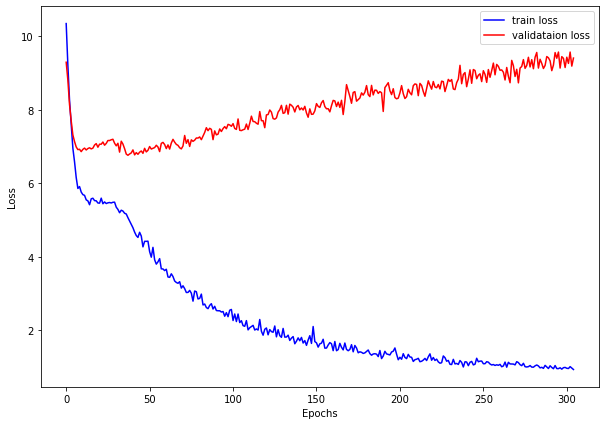

In [23]:
save_plots(train_acc, valid_acc, train_loss, valid_loss)

## Test Model

In [24]:
trained_model = torch.load(
    os.path.join(CHECKPOINT_DIR, 'model.pth')
)

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [25]:
# test_loss = validate(
#     trained_model, 
#     dataset_test,  
#     criterion, 
#     device
# )

# print(f"Test loss: {test_loss}")

## Text Generation

In [ ]:
def return_int_vector(enc, text):
        """
        Assign an integer to each word and return the integers in a list.
        """
        return enc.encode(text)

In [ ]:
enc = tiktoken.encoding_for_model("gpt2")

In [ ]:
def sample_next(predictions, temperature=1.0):
    """
    Implement variable-temperature sampling from a probability
    distribution.
    """
    predictions = predictions.squeeze(0)[-1, :] / temperature
    predictions = predictions.exp().cpu()
    next_token = torch.multinomial(predictions, num_samples=1)
    return int(next_token[0].cpu())
    

def text_generator(sentence, generate_length):
    trained_model.eval()
    temperatures = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 
    num_tokens = len(sentence)
    for temeperature in temperatures:
        sample = sentence
        print(f"GENERATED SENTENCE WITH TEMPERATURE {temeperature}")
        for i in range(generate_length):
            int_vector = return_int_vector(enc, sample)
            input_tensor = torch.tensor(int_vector, dtype=torch.int32)
            input_tensor = input_tensor.unsqueeze(0).to(device)
            with torch.no_grad():
                predictions = trained_model(input_tensor)
            next_token = sample_next(predictions)
#             if next_token != 0: # Ignore <pad> index. Final sentence may be shorter.
            sample += ' ' + enc.decode([next_token])
        print(sample)
        print('\n')

In [ ]:
generate_length = 128

In [ ]:
sentences = [
    "Alice was a curious and imaginative young girl who lived in a quiet village."
]

In [ ]:
for sentence in sentences:
    print(f"PROMPT: {sentence}")
    text_generator(sentence, generate_length)
    print('\n############\n')